# 11-9. 프로젝트 : 주식 예측에 도전해 보자

ARIMA를 통해 시계열 데이터를 예측하는 과정을 진행해 보았습니다. 이제 실제 주식값 예측에 도전해 봅시다. 데이터는 과거의 일자별 시세입니다. 우선 대한민국 대장주 삼성전자에 대한 주식 시세를 예측해 봅시다.

![](https://d3s0tskafalll9.cloudfront.net/media/images/E-16-5.max-800x600.png)

위 그림과 같이 [Yahoo Finance](https://finance.yahoo.com/)에서 오늘 사용할 데이터셋을 다운로드할 수 있습니다.

<br>

하지만 이전 스텝을 차근차근 진행하셨다면, 이미 데이터셋이 `stock_prediction/data` 에 올라와 있을 것입니다.
아래 명령어로 `005930.KS.csv` 파일이 존재하는지 확인해 봐요.

<br>

```
$ cd ~/aiffel/stock_prediction/data
$ ls
```

<br>

만약 해당 파일이 없다면 다음과 같이 실행해 주세요.

<br>

```
$ mkdir -p ~/aiffel/stock_prediction/data
$ ln -s ~/data/* ~/aiffel/stock_prediction/data
```

<br>

이후 순서는 다음과 같습니다. 필요한 내용은 이미 앞에서 다 다루었기 때문에 이후 과정은 여러분들이 직접 수행해 보시기를 바랍니다.



# STEP 1 : 시계열 데이터 준비

- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.
- 우리는 종가(Close)만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/005930.KS.csv' 
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)

In [ ]:
# 데이터프레임 구조를 확인
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284
...,...,...,...,...,...,...
2021-05-12,80800.0,81200.0,79800.0,80000.0,80000.000000,35812268
2021-05-13,78900.0,79600.0,78400.0,78500.0,78500.000000,31490096
2021-05-14,79000.0,80300.0,78900.0,80100.0,80100.000000,16450920


- 인덱스로는 'Date'
- 시리즈는 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'이 있다.

In [ ]:
ts = df['Close']
ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

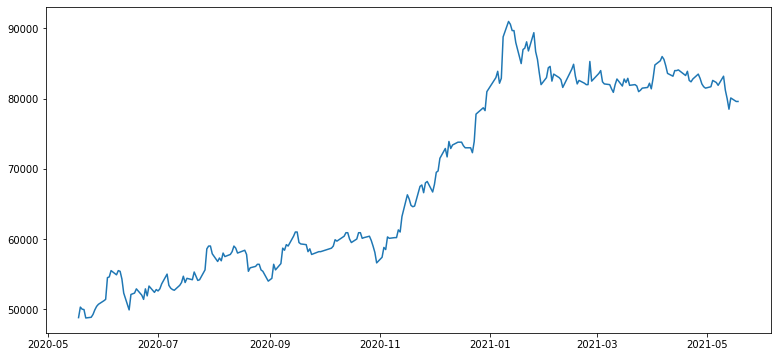

In [ ]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)

# STEP 2 : 각종 전처리 수행

- 결측치 처리
- 로그 변환

## 결측치 처리

- **시간을 index로 가지는 시계열 데이터**이므로 <u>삭제하는 것보다는 **보간**하는 방법을 사용</u>하는 것이 낫다.
- Pandas에서 결측치 보간을 처리하는 메서드는 다음과 같다

Series([], Name: Close, dtype: float64)


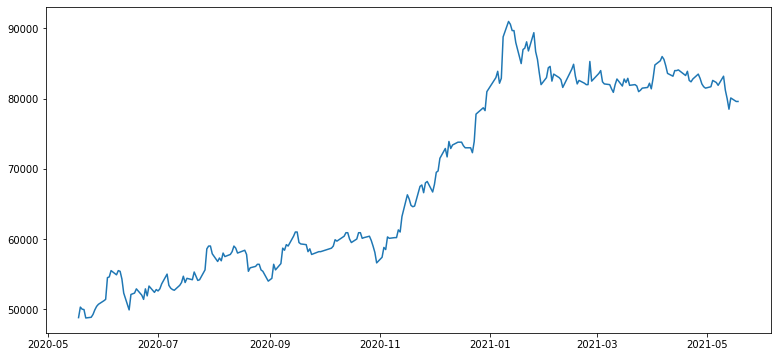

In [ ]:
# 결측치가 있다면 이를 보간합니다. 보간 기준은 time을 선택합니다. 
ts = ts.interpolate(method='time')

# 보간 이후 결측치(NaN) 유무를 다시 확인합니다.
print(ts[ts.isna()])

# 다시 그래프를 확인해봅시다!
plt.plot(ts)

- 결측치가 없었다.

- 일정한 패턴이 없는 불안정적(Non-Stationary)인 시계열 데이터이다.
- 불안정적인 시계열 데이터는 **ADF** 테스트를 이용해 보기로 한다.

## 로그변환

- 시계열이 시간 추이에 따라 분산이 점점 커지고 있는 경우에는 로그함수로 변환을 해주는 것이 도움이 된다고 한다.
- 아직은 그래프를 그냥 봤을때, 분산이 엄청나게 커지고 있는지 확인이 되지 않음
- 뒤에서 *정성적 그래프 분석*을 통해서 분산 추이를 알아보고 난 후에 로그변환을 진행하도록 한다. **(여기서는 하지 않는다.)**

In [ ]:
# 로그 변환
# ts_log = np.log(ts)
# plt.figure(figsize=(15,7))
# plt.plot(ts_log)

# STEP 3 : 시계열 안정성 분석

- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

## 구간 통계치(Rolling Statistics)를 시각화 (정성적 그래프 분석)

현재 타임 스텝 부터 window에 주어진 타임 스텝 이전 사이

1. 구간의 평균(rolling mean, **이동평균**)과
2. 표준편차(rolling std, **이동표준편차**)를

원본 시계열과 함께 시각화해 보면 좀 더 뚜렷한 경향성을 확인할 수 있다.

In [ ]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('슝=3')

슝=3


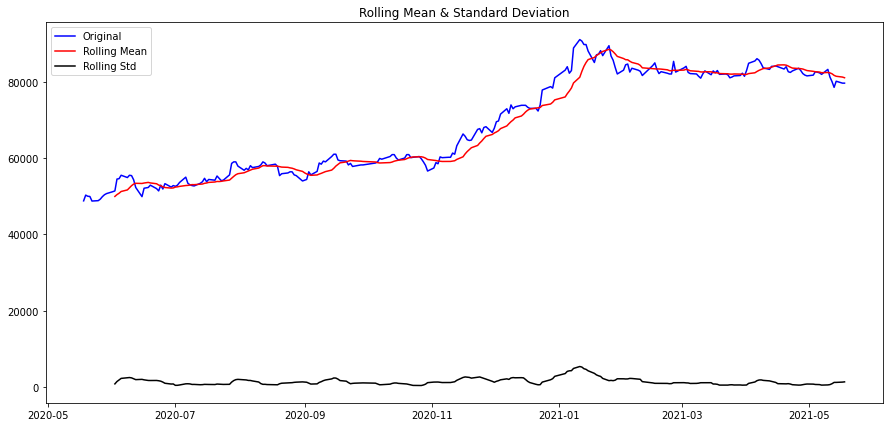

In [ ]:
plt.figure(figsize=(15,7))
plot_rolling_statistics(ts, window=12)

- 아까 STEP 2에서 **분산**이 점점 커지는 시계열 데이터일 경우 **로그 변형**을 시키는 것이 좋다고 했는데, *정성적 그래프 분석*을 보니 <u>분산이 커지고 있지 않다.</u> 👉 ***로그 변형을 하지 않고 진행한다***

## Augmented Dickey-Fuller Test (정량적 분석)

**Augmented Dickey-Fuller Test(ADF Test)** 라는 시계열 데이터의 안정성(stationary)을 테스트하는 통계적 방법을 사용한다.

<br>

> 1. `**주어진 시계열 데이터가 안정적이지 않다**`라는 `**귀무가설(Null Hypothesis)**`를 세운 후,<br><br>
2. 통계적 가설 검정 과정을 통해 이 귀무가설이 기각될 경우에<br><br>
3. `**이 시계열 데이터가 안정적이다**`라는 `**대립가설(Alternative Hypothesis)**`을 채택한다<br><br>


statsmodels 패키지에서 제공하는 adfuller 메서드를 이용해 손쉽게 ADF Test의 결과를 이용해본다. 🤗

<br>

- ADF 검정은 정상성을 알아보기 위한 단위근 검정 방법
- 단위근(unit root)이란 $x=1$, $y=1$인 해로, 시계열 자료에서 예측할 수 없는 결과를 가져올 수 있다.
- 검정에는 자료에 단위근이 존재한다는 **귀무가설**(Null Hyperthesis, $H_0: \alpha = 1$과 자료에 단위근이 존재하지 않아 시계열 자료가 정상성을 만족한다는 **대립가설**(Alternative HypothesisH_1: $\alpha \ne 1$), 이렇게 2가지 가설을 사용한다.
- 검정을 통해 귀무가설을 기각하면 정상성을 띤다고 볼 수 있다.

<br>

- 조금 더 자세히 설명하면, ADF 검정은 1979년 David Dickey와 Wayne Fuller에 의해 개발된 DF 검정을 일반화한 검정이다.
- Dickey-Fuller 단위근 검정은 단위근이 존재한다는 귀무가설을 통계적으로 검정하는 방법

<br>

$$y_t = c + \beta t + \alpha y_{t-1} + \phi \nabla y_{t-1} + e_t$$

<br>

- 데이터의 레벨, $\beta$는 시계열 데이터의 추세항이다.
- 각 파라미터를 regression으로 추정해 $\alpha$가 단위근을 가질 확률을 검정. $\alpha=1$이면 단위근을 가지는 것이기 때문에 정상성을 띠지 않는다고 판단한다.

<br>

- ADF 검정은 DF 검정에 `p lag`의 차분을 추가해 검정 능력을 더 강화시켰다. 식은 아래와 같다.

<br>

$$y_t = c + \beta t + \alpha y_{t-1} + \phi_1 \nabla y_{t-1} + ... + \phi_p \nabla y_{t-p} + e_t$$

<br>

- DF 검정의 식에서 `p lag`의 차분만큼 항이 추가되어 있다.
- $t-p$ 시점까지의 차분 경향성을 파악할 수 있어서 주기를 가진 데이터의 정상성 여부를 판단할 수 있다.

<br>

- **ADF 검정의 귀무가설**은 DF 검정과 귀무가설이 같으므로 <u>검정통계량이 Critical Value보다 작거나 p-value가 설정한 유의수준 값보다 작으면</u> ***정상적인 시계열 데이터***라고 볼 수 있다.


**statsmodels 패키지와 adfuller 메서드**

아래는 `statsmodels` 패키지에서 제공하는 `adfuller` 메서드를 이용해 주어진 **timeseries에 대한 Augmented Dickey-Fuller Test를 수행하는 코드**

In [ ]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')

슝=3


In [ ]:
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -1.222649
p-value                          0.663778
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


- ts(Daily Minimum Temperatures in Melbourne)시계열이 안정적이지 않다는 귀무가설은 p-value가 **약 0.66**으로 나왔다.
- p-value가 **0.05** 미만으로 매우 낮게 나온다면 p-value만큼의 오류 가능성 하에 귀무가설을 기각하고 대립가설을 채택할 수 있는 근거가 되지만, 지금은 **약 0.66**이라는 높은 값이 나왔으므로, <u>이 시계열은 안정적이지 않다는 귀무가설을 기각할 수는 없게 되었으므로</u> **이 시계열이 안정적인 시계열이라고 말할 수는 없다.**

## 시계열 분해(Time series decomposition)

- 안정적인(Stationary) 시계열로 만드는 방법에는 두 가지가 있다.
- 위에서 사용했던 정석적인 분석을 통해 보다 안정적인 특성을 가지도록 **기존의 시계열 데이터를 가공/변형**하는 시도 👉 분산이 커지는 추이라면 로그변환을 하는 것이 좋다고 했으나, 분산이 커지는 추이는 보이지 않았으므로 하지않음
- 두번째는 **시계열 분해(Time series decomposition)** 기법을 적용하는 것

- statsmodels 라이브러리 안에는 `seasonal_decompose` 메서드를 통해 시계열 안에 존재하는 **trend**, **seasonality**를 <u>직접 분리해 낼 수 있는 기능</u>이 있다.
- 이 기능을 활용하면 예제에서 직접 수행했던 **moving average 제거**, **differencing** 등을 거치지 않고도 <u>훨씬 안정적인 시계열을 분리해 낼 수 있게 된다.</u>

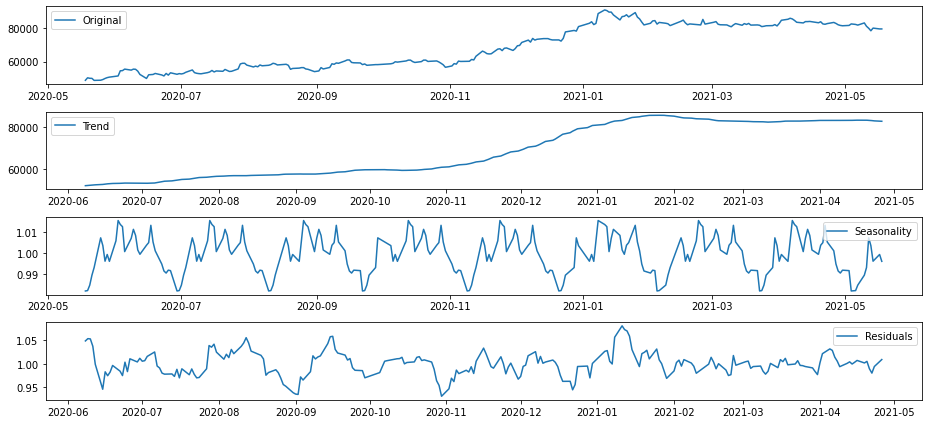

In [ ]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

- `Original` 시계열에서 `Trend`와 `Seasonality`를 제거하고 난 나머지를 `Residual`이라고 한다. 
- ***Trend+Seasonality+Residual=Original*** 이 성립한다는 뜻
- 이러한 **Decomposing**은 <u>시계열 데이터를 이해하는 중요한 관점을 제시</u>해 준다.

<br>

그렇다면 이제 Residual에 대해 안정성 여부를 따져 보자

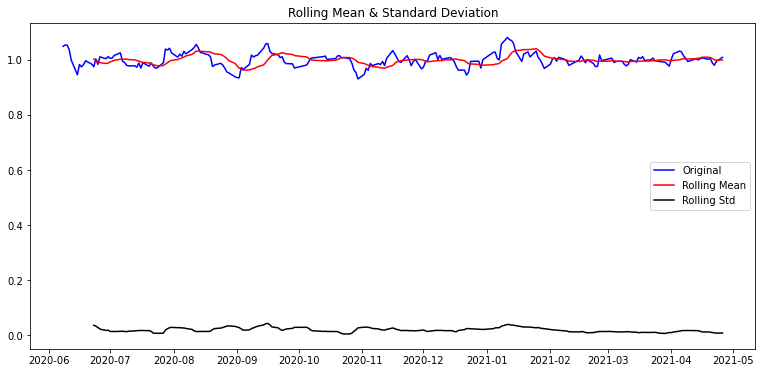

In [ ]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [ ]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.170429e+00
p-value                        6.826344e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


- `Decomposing`을 통해 얻어진 `Residual`은 압도적으로 낮은 `p-value`가 나타난다.
- 이 정도면 확실히 <u>예측 가능한 수준의</u> **안정적인 시계열이 얻어졌다**고 볼 수 있다.

# STEP 4 : 학습, 테스트 데이터셋 생성

- 학습, 테스트 데이터셋 분리 (**9:1** 비율로 분리)

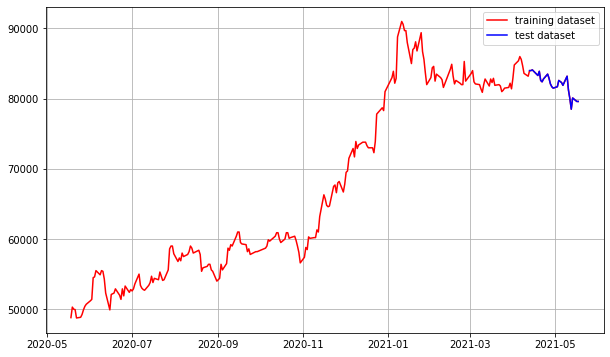

In [ ]:
train_data, test_data = ts[:int(len(ts)*0.9)], ts[int(len(ts)*0.9):]  
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

- 데이터셋의 형태를 확인

In [ ]:
print(ts[:2])
print('\n')
print(train_data.shape)
print(test_data.shape)

Date
2020-05-18    48800.0
2020-05-19    50300.0
Name: Close, dtype: float64


(225,)
(25,)


# STEP 5 : 적정 ARIMA 모수 찾기

- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

## ARIMA 모델의 모수 p, q, d

- ARIMA를 효과적으로 활용하기 위해서는 **ARIMA의 모수(parameter)**를 잘 설정해야 한다.
- 핵심적인 숫자들을 잘 정해야 올바른 예측식을 구할 수 있다는 것

<br>

---
- ARIMA의 모수는 3가지가 있다.

<br>

1. `p` : 자기회귀 모형(AR)의 시차
2. `d` : 차분 누적(I) 횟수
3. `q` : 이동평균 모형(MA)의 시차

<br>

- 이 중 `p` 와 `q` 는 일반적으로 `p + q < 2`, `p * q = 0` 인 값을 사용하는데, 이는 <u>p 나 q 중 하나는 0</u>이라는 뜻
- 이렇게 하는 이유는 많은 시계열 데이터가 <u>`AR`이나 `MA` 중 하나의 경향만 가지기 때문이다.</u>

<br>

---

**모수 `p`, `q`, `d`를 결정하는 방법 2가지**

<br>

- 여러 방법들이 있지만, `ACF(Autocorrelation Function)`와 `PACF(Partial Autocorrelation Function)` 두 가지를 대표적으로 사용한다.
- 이 AutoCorrelation은 맨 첫 스텝에서 다룬 개념 중 하나인 **자기상관계수**와 같은 것이다.

<br>

`ACF`

<br>

- 시차(lag)에 따른 관측치들 사이의 관련성을 측정하는 함수
- 주어진 시계열의 현재 값이 과거 $(y_{t-1}, y_{t-2}, ...., y_{t-n})$ 값과 어떻게 상관되는지 설명함.
- ACF plot에서 X 축은 상관 계수를 나타냄, y축은 시차 수를 나타냄

<br>

`PACF`

- **다른 관측치의 영향력을 배제**하고 두 시차의 관측치 간 관련성을 측정하는 함수
- k 이외의 모든 시차를 갖는 관측치$(y_{t-1}, y_{t-2}, ...., y_{t-k+1})$의 영향력을 배제한 가운데 특정 두 관측치, $y_{t}$와 $y_{t-k}$가 얼마나 관련이 있는지 나타내는 척도.

<br>

---

- `statsmodels`에서 제공하는 `ACF`와 `PACF` 플로팅 기능을 사용할 예정

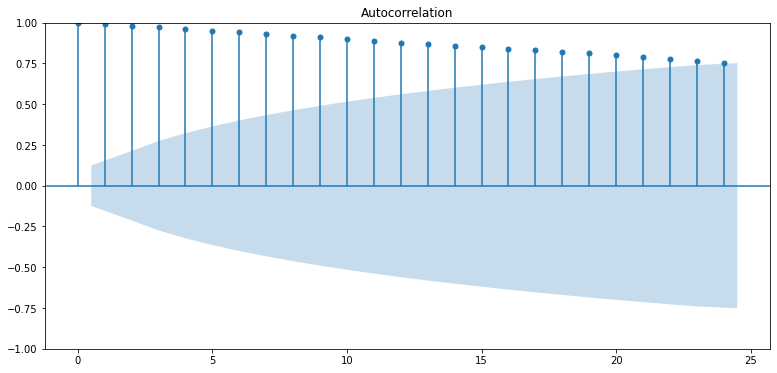

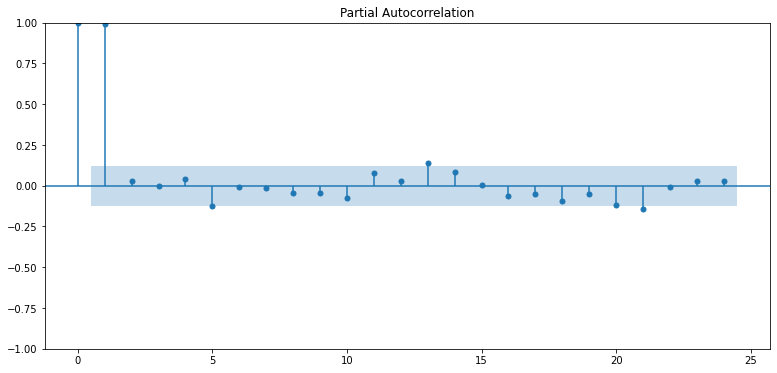

In [ ]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

![](https://d3s0tskafalll9.cloudfront.net/media/images/E-16-4.max-800x600.png)


- `PACF` 그래프를 볼 때 `p=1`이 적합하다. `p`가 2 이상인 구간에서 `PACF`는 거의 0에 가까워지고 있기 때문
- `PACF`가 0이라는 의미는 현재 데이터와 p 시점 떨어진 이전의 데이터는 ***상관도가 0***, 즉 아무 상관 없는 데이터이기 때문에 <u>고려할 필요가 없다는 뜻</u>이다.
- 반면 `ACF`는 점차적으로 감소하고 있어서 `AR(1)` 모델에 유사한 형태를 보이고 있다. 
- `q`에 대해서는 적합한 값이 없다.

<br>

---
- `d`를 구하기 위해서는 `d`차 차분을 구해 보고 이때 시계열이 안정된 상태인지를 확인해 보아야 한다.

Results of Dickey-Fuller Test:
Test Statistic                -1.541059e+01
p-value                        3.127307e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.073769e+01
p-value                        2.870899e-19
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


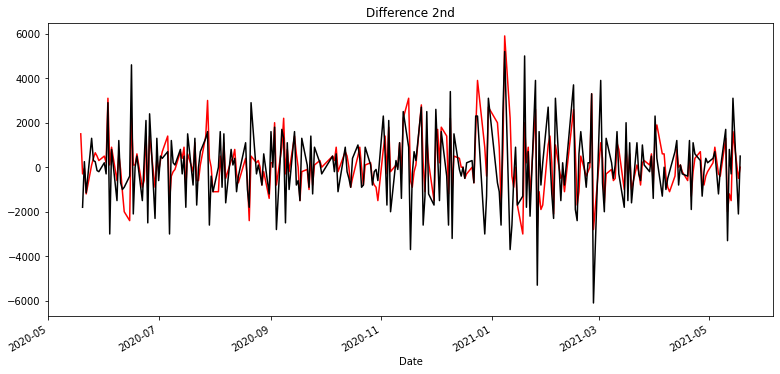

In [ ]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st', color='red')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd', color='black')

augmented_dickey_fuller_test(diff_2)

- 2차 차분이 1차 차분에 비해서 진폭이 크다.
- `d=1`로 먼저 시도해 볼 수 있을 것 같다. 
- `d` 값도 바꿔 가면서 최적의 값을 찾아본다.

# STEP 6 : ARIMA 모델 훈련과 테스트

- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -1919.806
Date:                Thu, 17 Feb 2022   AIC                           3849.612
Time:                        19:35:14   BIC                           3866.693
Sample:                             0   HQIC                          3856.506
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.669e+04   1.25e+04      5.348      0.000    4.22e+04    9.11e+04
ar.L1          0.0164      0.019      0.872      0.383      -0.020       0.053
ar.L2          0.9774      0.019     51.895      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


- ARIMA 모델이 훈련 결과를 시각적으로 확인한다.

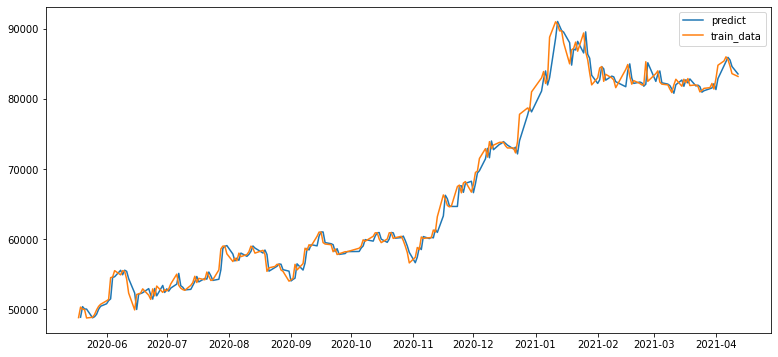

In [ ]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

- `forecast()` 메소드를 이용해 테스트 데이터 구간의 데이터를 예측

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


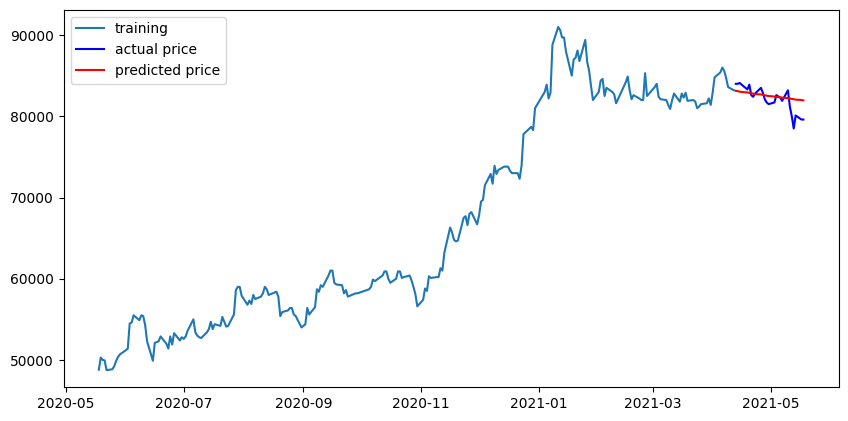

In [ ]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

- 예제에서는 시계열 데이터를 로그 변환하여 사용했으므로 다시 지수 변환해야 정확한 오차를 계산할 수 있었다.
- 하지만 <u>지금 프로젝트에서는 로그변환을 하지 않았기 때문에</u> 그대로 **`MSE`**, **`MAE`**, **`RMSE`**, **`MAPE`**를 계산한다.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(test_data, fc)
print('MSE: ', mse)

mae = mean_absolute_error(test_data, fc)
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: ', rmse)

mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1714648.814005477
MAE:  999.2887729579373
RMSE:  1309.4459950702346
MAPE: 1.23%


- **`MAPE`**는 **1.23%**. 
- 평균 절대 백분율 오차(MAPE)는 ***정확도***를 <u>오차의 백분율로 표시</u>한다. **값이 낮을 수록 정확도가 높다**고 한다. 그래서 예측모델의 메트릭으로 사용하기에 적합한 지수이다.
- *더 적당한 모수*를 찾을 수 있다면 개선의 여지가 있다. 조금더 다양한 테스트를 거쳐 최적화된 모델을 만들어 보자

# 회고

## 루브릭 평가 지표를 맞추기 위해 시도한 것들

|평가문항|상세기준|
|:------|:---|
|1. 시계열의 안정성이 충분히 확인되었는가?|플로팅과 adfuller 메소드가 모두 적절히 사용되었음|
|2. ARIMA 모델 모수선택 근거를 체계적으로 제시하였는가?|p,q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 명확히 제시됨|
|3. 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가?.|3개 이상 종목이 MAPE 15% 미만의 정확도로 예측됨|

- **`MAPE`**는 **1.23%**으로 매우 낮은 오차율을 보였다.

## 만약에 루브릭 평가 관련 지표를 달성 하지 못했을 때, 이유에 관한 추정

    

- 다른 종목에 도전하지 못했다.


## 아쉬운 점

- 지금까지 해왔던 익플 1~10에 과도하게 열중해서 번아웃이 온 것 같다. 너무 힘들어서 백지로 낼까 고민했을 정도였는데... 그래도 기본 코드라도 봐보자 하는 마음으로 훑어봄. 다른 때와 달리 내용이 짧다.
- 주말 푹 쉬고, 다음주부터는 다시 열심히 해야겠다... 너무 힘들다.